# Fingerprints

In [2]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os,sys,inspect
import pickle
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(13-Jun-2017) I come back to this code to optimize it. I shall try to put the whole operation in a single line of code by defining adequate matrices and vectorized functions.

## No. 1 SIL 18 (optimized code) (13-Jun-2017)

In [3]:
# This here imports a set of A,B values taken from a perfect diamond lattice.
# A upper bound has been imposed.
# And a lower bound corresponding to a maximum distance from the NV.
all_spins = 2*np.pi*1000 * np.genfromtxt('complete_lattice.csv', delimiter=',') # imported in Hz
all_spins[:,1] = np.abs(all_spins[:,1])
#all_spins = all_spins[0:100]

In [4]:
# taken from /Users/juan/Downloads/fitting_fingerprints/fitting_fingerprints/hyperfine_params.py
# NOTE: this are for ms = -1
hyperfine_params = {} # I'm assuming that these come in Hz
hyperfine_params['C1']  = {'par' : -36.0e3, 'perp':25.0e3}
hyperfine_params['C2']  = {'par' : 21.2e3, 'perp':43.0e3}
hyperfine_params['C3']  = {'par' : -11.0e3, 'perp':55.0e3}
hyperfine_params['C4']  = {'par' : 8.1e3, 'perp':21.0e3}
hyperfine_params['C5']  = {'par' : 24.7e3, 'perp':26.0e3}
hyperfine_params['C6']  = {'par' : -48.7e3, 'perp':12.0e3}
hyperfine_params['C7']  = {'par' : 14.5e3, 'perp':11.0e3}
# hyperfine_params['C8']  = {'par' : -20.5e3, 'perp':21.0e3}
hyperfine_params['C8']  = {'par' : 7.32e3, 'perp':5.0e3}
par_params = []
perp_params = []
for llave in hyperfine_params.keys(): # convert to rad/s
    par_params.append(2.*np.pi*hyperfine_params[llave]['par'])
    perp_params.append(2.*np.pi*hyperfine_params[llave]['perp'])

In [5]:
# from https://gist.github.com/alimuldal/f900f2a3e676348bc34b
def unique_rows(a, **kwargs):

    rowtype = np.dtype((np.void, a.dtype.itemsize * a.shape[1]))
    b = np.ascontiguousarray(a).view(rowtype)
    return_index = kwargs.pop('return_index', False)
    out = np.unique(b, return_index=True, **kwargs)
    idx = out[1]
    uvals = a[idx]
    if (not return_index) and (len(out) == 2):
        return uvals
    elif return_index:
        return (uvals,) + out[1:]
    else:
        return (uvals,) + out[2:]

In [6]:
# because of symmetry the
# there is degeneracy in the all_spins set
# I will assume it very unlikely for this to be relevant
# and will eliminate the redundancy for computational efficacy
all_spins = unique_rows(all_spins)

In [7]:
all_spins.shape

(9879, 2)

In [8]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = -1
omega_larmor = -1. * ms * gam_c * B_field

In [9]:
# Import experimental data for the different number of sequences values.
sil18={}
magic_Ns=[4,8,16,32,64]
for num in magic_Ns:
    sil18[num] = np.transpose(np.loadtxt('/Users/juan/Downloads/fitting_fingerprints/sil18_fingerprint_ms_min_N'+str(num)+'.txt'))

In [10]:
sample = sil18[64][:,1]
tau_times = sil18[64][:,0]*10**(-6)

In [11]:
# I will now make an array which has in each row the time signature associated with the corresponding A,B values.
all_single_Ms = analysis.calc_M_single(all_spins[:,0],all_spins[:,1],64,omega_larmor,tau_times[:,None]);
all_single_Ms=all_single_Ms.transpose();

In [12]:
#pickle.dump(all_single_Ms,open('all_single_Ms_min.pkl','wb'))
#all_single_Ms=pickle.load(open('all_single_Ms.pkl','rb'))

In [17]:
sample_norm = np.sqrt(sum(sample**2))
fitted_M = np.ones(len(sample))
remaining_Ms = all_single_Ms
remaining_spins = all_spins
similarity_path = []
fit_path = []
chosen_spins = []


for i in range(25):
    print('cycle='+str(i+1))
    # calculate new Ms
    the_Ms = remaining_Ms * fitted_M
    # calculate the norms
    the_Ms_norms =  np.sqrt(np.sum(the_Ms**2,axis=1))
    # calculate new similarities with experimental data
    similarities = np.dot(the_Ms,sample)/(the_Ms_norms * sample_norm)
    # find the closest one that hasn't been already been chosen
    best_spin_arg = np.argmax(similarities)
    similarity_path.append(similarities[best_spin_arg])
    # update fitted_M
    fitted_M = the_Ms[best_spin_arg]
    # update chosen_spins
    chosen_spins.append(remaining_spins[best_spin_arg])
    fit_path.append(fitted_M)
    # update remaining_Ms
    remaining_Ms = np.delete(remaining_Ms, best_spin_arg,axis=0)
    remaining_spins = np.delete(remaining_spins,best_spin_arg,axis=0)


cycle=1
cycle=2
cycle=3
cycle=4
cycle=5
cycle=6
cycle=7
cycle=8
cycle=9
cycle=10
cycle=11
cycle=12
cycle=13
cycle=14
cycle=15
cycle=16
cycle=17
cycle=18
cycle=19
cycle=20
cycle=21
cycle=22
cycle=23
cycle=24
cycle=25


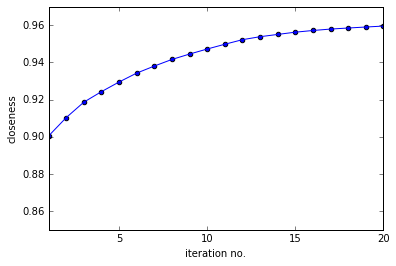

In [18]:
plt.figure()
plt.scatter(1.+np.arange(len(similarity_path)),similarity_path)
plt.plot(1.+np.arange(len(similarity_path)),similarity_path)
plt.xlabel('iteration no.')
plt.ylabel('closeness')
plt.xlim(1,20)
plt.ylim(0.85,0.97)
plt.show()

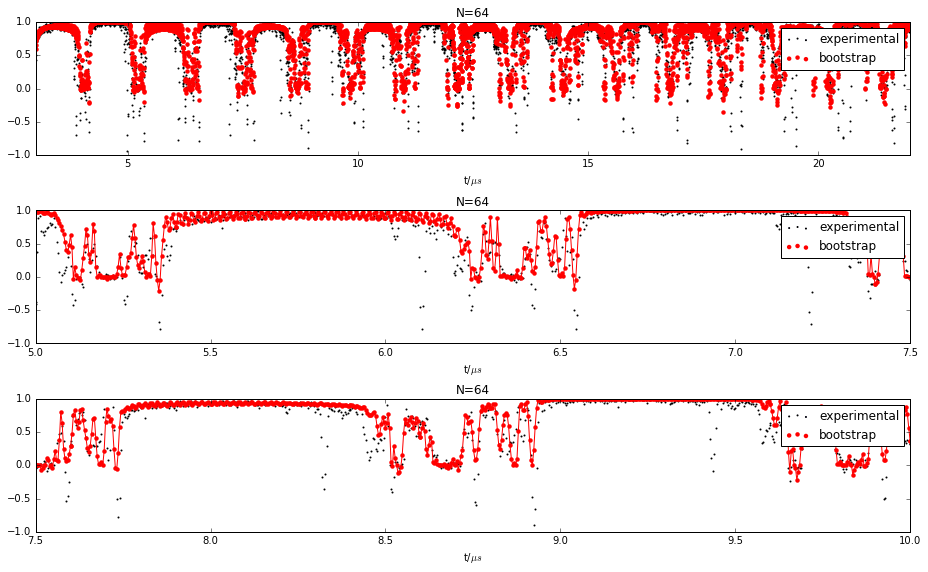

In [524]:
plt.figure(figsize=(13,8))
plt.subplot(3,1,1)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[64][:,0]),max(sil18[64][:,0]))
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],fitted_M,'r')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],fitted_M,'r')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
chosen_spins = np.array(chosen_spins)
fitted_As = chosen_spins[:,0]
fitted_Bs = chosen_spins[:,1]

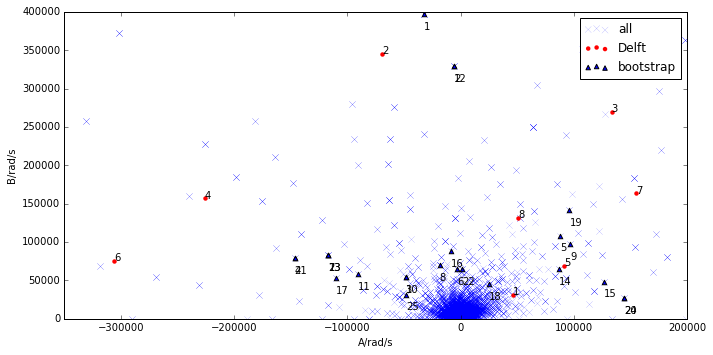

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1,label='all')
plt.scatter(par_params,perp_params,c='r',lw=0,label='Delft')
plt.scatter(fitted_As,fitted_Bs,marker='^',label='bootstrap')
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
for i in range(len(fitted_As)):
    plt.text(fitted_As[i],fitted_Bs[i]-20000,str(i+1))
plt.legend()
plt.tight_layout()
plt.show()

In [131]:
## This is faulty
# Calculate M that corresponds to Taminaiu's fitted values
# tims_fit=analysis.calc_M(par_params, perp_params, 64, omega_larmor, tau_times)

In [21]:
# Make a correct plot of the fitted result from Delft
delft64 =  pickle.load(open('/Users/juan/Downloads/fitting_fingerprints/min64.pkl','rb'))

In [22]:
# calculate the total M
total64 = np.ones(len(delft64['M'][0]))
for i in range(len(delft64['M'])):
    total64 *= delft64['M'][i]

In [23]:
together = np.interp(sil18[64][:,0], delft64['taus']*10**6,total64) * fitted_M

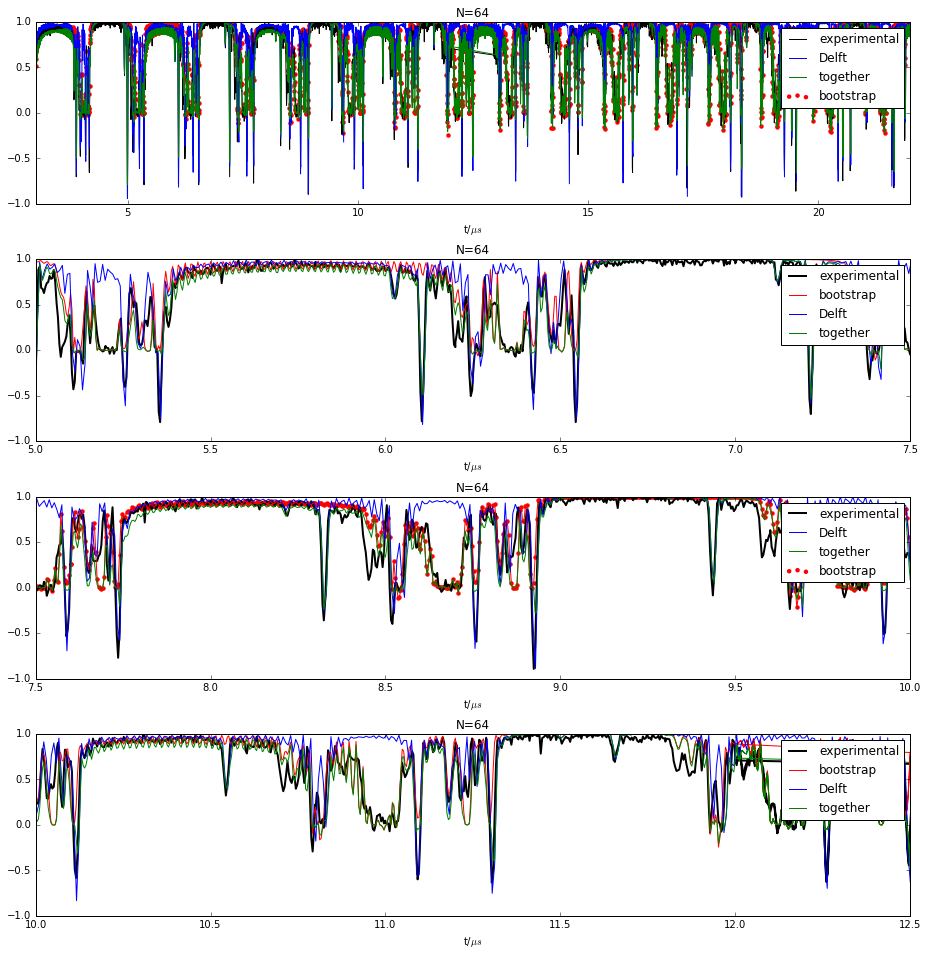

In [36]:
# Overlay it with the other fits
plt.figure(figsize=(13,10./3.*4.))

plt.subplot(4,1,1)
#plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
plt.plot(sil18[64][:,0],sil18[64][:,1],'k',label='experimental',lw=1)
plt.plot(delft64['taus']*10**6,total64,'b',label='Delft')
plt.scatter(sil18[64][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],together,'g',label='together')
plt.xlim(min(sil18[64][:,0]),max(sil18[64][:,0]))
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()

plt.subplot(4,1,2)
#plt.plot(sil18[64][:,0],sil18[64][:,1],label='experimental')
plt.plot(sil18[64][:,0],sil18[64][:,1],'k',label='experimental',lw=2)
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
#plt.scatter(sil18[64][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],fitted_M,'r',label='bootstrap')
plt.plot(delft64['taus']*10**6,total64,'b',label='Delft')
plt.plot(sil18[64][:,0],together,'g',label='together')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()

plt.subplot(4,1,3)
#plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
plt.plot(sil18[64][:,0],sil18[64][:,1],'k',label='experimental',lw=2)
plt.scatter(sil18[64][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],fitted_M,'r')
plt.plot(delft64['taus']*10**6,total64,'b',label='Delft')
plt.plot(sil18[64][:,0],together,'g',label='together')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()

plt.subplot(4,1,4)
#plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
plt.plot(sil18[64][:,0],sil18[64][:,1],'k',label='experimental',lw=2)
plt.plot(sil18[64][:,0],fitted_M,'r',label='bootstrap')
plt.plot(delft64['taus']*10**6,total64,'b',label='Delft')
plt.plot(sil18[64][:,0],together,'g',label='together')
plt.xlim(10,12.5)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()

plt.tight_layout()
plt.savefig('/Users/juan/Dropbox/plot1497621149.pdf')
plt.show()

In [61]:
np.corrcoef(sample,fitted_M)

array([[ 1.        ,  0.81258757],
       [ 0.81258757,  1.        ]])

In [60]:
np.corrcoef(sample,np.interp(sil18[64][:,0], delft64['taus']*10**6,total64))

array([[ 1.        ,  0.60663686],
       [ 0.60663686,  1.        ]])

In [62]:
np.corrcoef(sample,together)

array([[ 1.        ,  0.86917862],
       [ 0.86917862,  1.        ]])

In [ ]:
np.corrcoef()

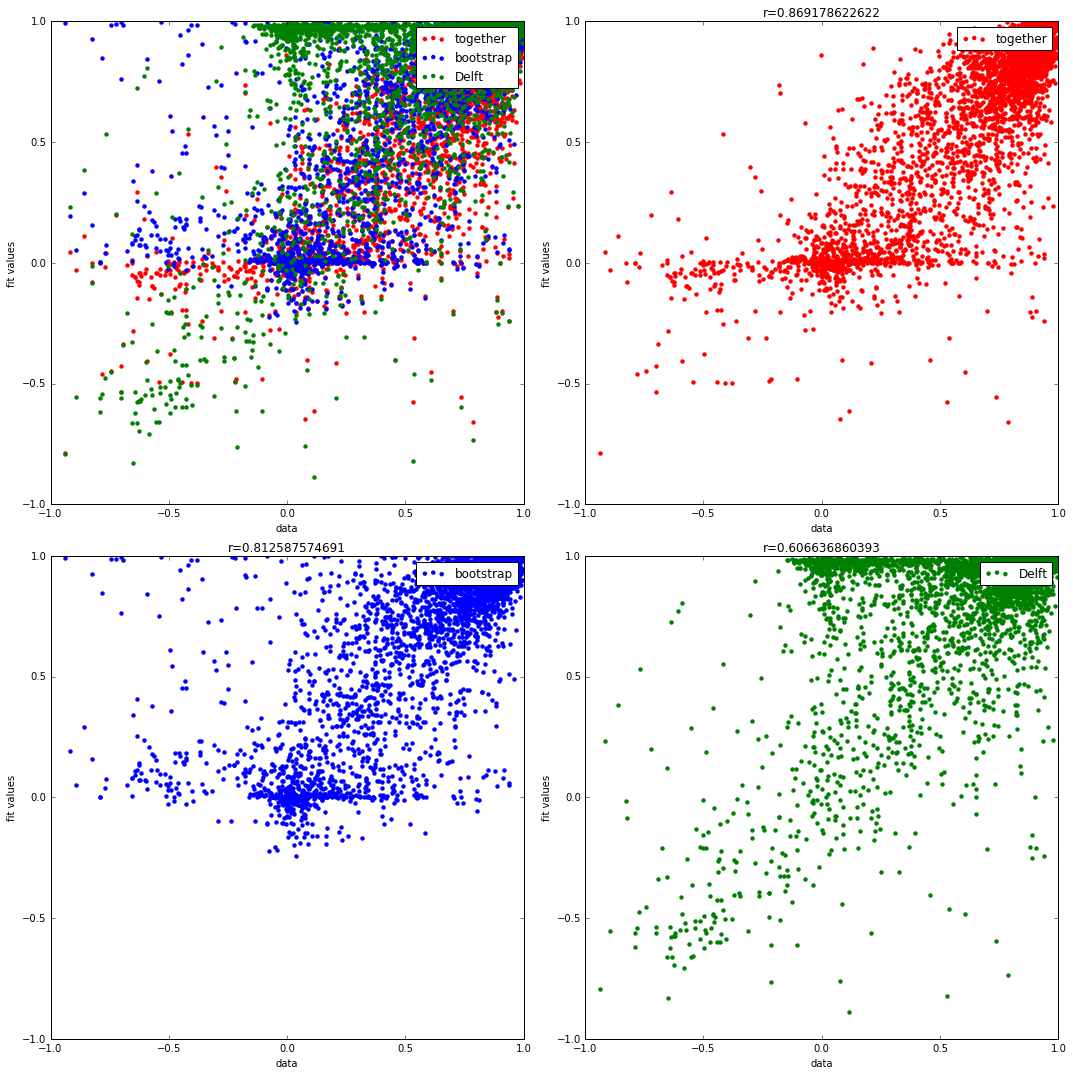

In [69]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.scatter(sample,together,c='r',lw=0,label='together')
plt.scatter(sample,fitted_M,c='b',lw=0,label='bootstrap')
plt.scatter(sample, np.interp(sil18[64][:,0], delft64['taus']*10**6,total64),c='g',lw=0,label='Delft')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('data')
plt.ylabel('fit values')
plt.legend()

plt.subplot(2,2,2)
plt.scatter(sample,together,c='r',lw=0,label='together')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('data')
plt.ylabel('fit values')
plt.title('r='+str(np.corrcoef(sample,together)[0,1]))
plt.legend()

plt.subplot(2,2,3)

plt.scatter(sample,fitted_M,c='b',lw=0,label='bootstrap')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('data')
plt.ylabel('fit values')
plt.title('r='+str(np.corrcoef(sample,fitted_M)[0,1]))
plt.legend()

plt.subplot(2,2,4)

plt.scatter(sample, np.interp(sil18[64][:,0], delft64['taus']*10**6,total64),c='g',lw=0,label='Delft')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('data')
plt.ylabel('fit values')
plt.title('r='+str(np.corrcoef(sample,np.interp(sil18[64][:,0], delft64['taus']*10**6,total64))[0,1]))
plt.legend()

plt.tight_layout()
plt.savefig('/Users/juan/Google Drive/Zia Lab/Log/Graphs/plot1497622193.pdf')
plt.show()

In [33]:
np.dot(together,sample)/(np.sqrt(np.sum(together**2)) * sample_norm)

0.97013551030795808

In [586]:
np.dot(np.interp(sil18[64][:,0], delft64['taus']*10**6,total64) ,sample)/(np.sqrt(np.sum(np.interp(sil18[64][:,0], delft64['taus']*10**6,total64) **2)) * sample_norm)

0.92740473871915885

In [587]:
np.dot(fitted_M,sample)/(np.sqrt(np.sum(fitted_M**2)) * sample_norm)

0.95953008182093702

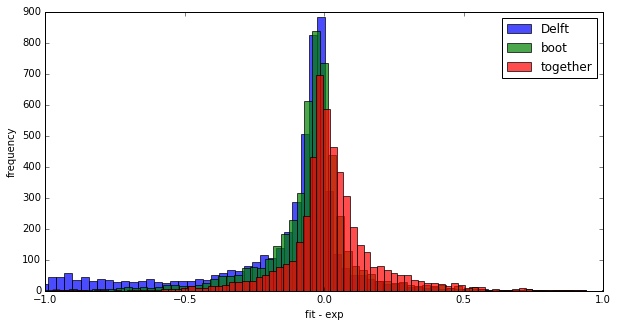

In [91]:
plt.figure(figsize=(10,5))
plt.hist(sample-np.interp(sil18[64][:,0], delft64['taus']*10**6,total64),bins=100,alpha=0.7,label='Delft')
plt.hist(sample-fitted_M,bins=100,alpha=0.7,label='boot')
plt.hist(sample-together,bins=100,alpha=0.7,label='together')
#np.interp(sil18[64][:,0], delft64['taus']*10**6,total64)
plt.xlim(-1,1)
plt.legend()
plt.xlabel('fit - exp')
plt.ylabel('frequency')
plt.show()

In [134]:
# save results for N=64
pickle.dump({'N':64, 'similarity_path':similarity_path, 'fit_path':fit_path, 'chosen_spins':chosen_spins},open('fingerprint_fit_N_64_minus.pkl','wb'))

In [ ]:
# now do N = 32

In [135]:
sample = sil18[32][:,1]
tau_times = sil18[32][:,0]*10**(-6)

In [136]:
# I will now make an array which has in each row the time signature associated with the corresponding A,B values.
all_single_Ms = analysis.calc_M_single(all_spins[:,0],all_spins[:,1],32,omega_larmor,tau_times[:,None]);
all_single_Ms=all_single_Ms.transpose();

In [137]:
pickle.dump(all_single_Ms,open('all_single_Ms_min_N_32.pkl','wb'))
#all_single_Ms=pickle.load(open('all_single_Ms.pkl','rb'))

In [138]:
sample_norm = np.sqrt(sum(sample**2))
fitted_M = np.ones(len(sample))
remaining_Ms = all_single_Ms
remaining_spins = all_spins
similarity_path = []
fit_path = []
chosen_spins = []

for i in range(20):
    print('cycle='+str(i+1))
    # calculate new Ms
    the_Ms = remaining_Ms * fitted_M
    # calculate the norms
    the_Ms_norms =  np.sqrt(np.sum(the_Ms**2,axis=1))
    # calculate new similarities with experimental data
    similarities = np.dot(the_Ms,sample)/(the_Ms_norms * sample_norm)
    # find the closest one that hasn't been already been chosen
    best_spin_arg = np.argmax(similarities)
    similarity_path.append(similarities[best_spin_arg])
    # update fitted_M
    fitted_M = the_Ms[best_spin_arg]
    # update chosen_spins
    chosen_spins.append(remaining_spins[best_spin_arg])
    fit_path.append(fitted_M)
    # update remaining_Ms
    remaining_Ms = np.delete(remaining_Ms, best_spin_arg,axis=0)
    remaining_spins = np.delete(remaining_spins,best_spin_arg,axis=0)


cycle=1
cycle=2
cycle=3
cycle=4
cycle=5
cycle=6
cycle=7
cycle=8
cycle=9
cycle=10
cycle=11
cycle=12
cycle=13
cycle=14
cycle=15
cycle=16
cycle=17
cycle=18
cycle=19
cycle=20


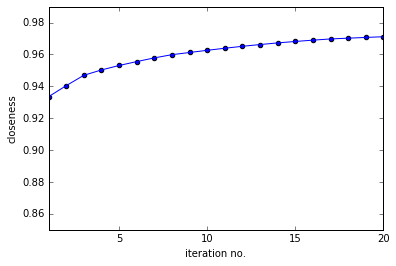

In [140]:
plt.figure()
plt.scatter(1.+np.arange(len(similarity_path)),similarity_path)
plt.plot(1.+np.arange(len(similarity_path)),similarity_path)
plt.xlabel('iteration no.')
plt.ylabel('closeness')
plt.xlim(1,20)
plt.ylim(0.85,0.99)
plt.show()

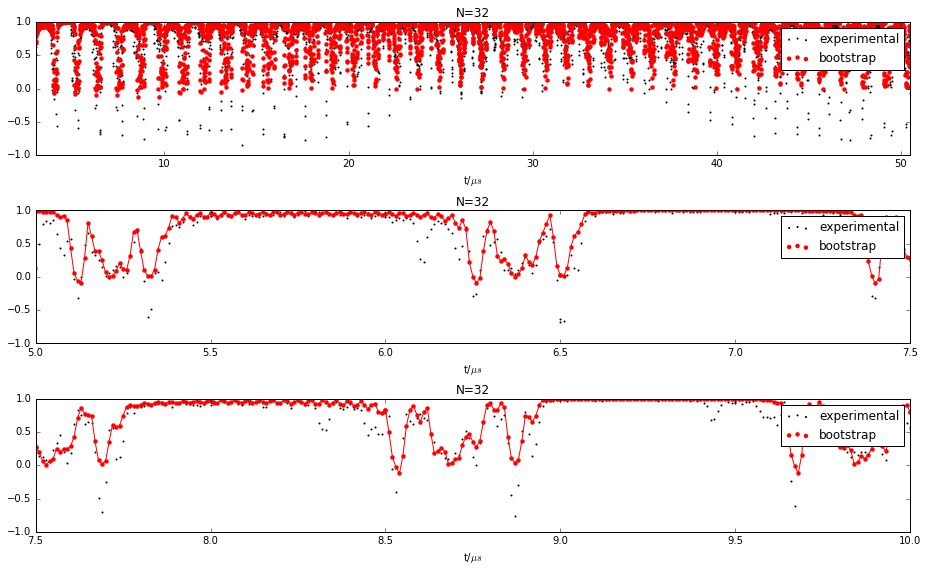

In [141]:
plt.figure(figsize=(13,8))
plt.subplot(3,1,1)
plt.scatter(sil18[32][:,0],sil18[32][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[32][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[32][:,0]),max(sil18[32][:,0]))
plt.ylim(-1,1)
plt.title('N=32')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(sil18[32][:,0],sil18[32][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[32][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[32][:,0],fitted_M,'r')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=32')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(sil18[32][:,0],sil18[32][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[32][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[32][:,0],fitted_M,'r')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=32')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

In [143]:
chosen_spins = np.array(chosen_spins)
fitted_As = chosen_spins[:,0]
fitted_Bs = chosen_spins[:,1]

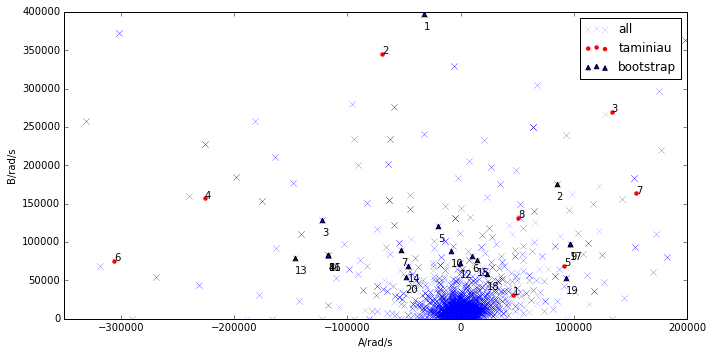

In [144]:
plt.figure(figsize=(10,5))
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1,label='all')
plt.scatter(par_params,perp_params,c='r',lw=0,label='Delft')
plt.scatter(fitted_As,fitted_Bs,marker='^',label='bootstrap')
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
for i in range(len(fitted_As)):
    plt.text(fitted_As[i],fitted_Bs[i]-20000,str(i+1))
plt.legend()
plt.tight_layout()
plt.show()

In [274]:
# Calculate M that corresponds to Taminaiu's fitted values
tims_fit=analysis.calc_M(par_params, perp_params, 32, omega_larmor, tau_times)

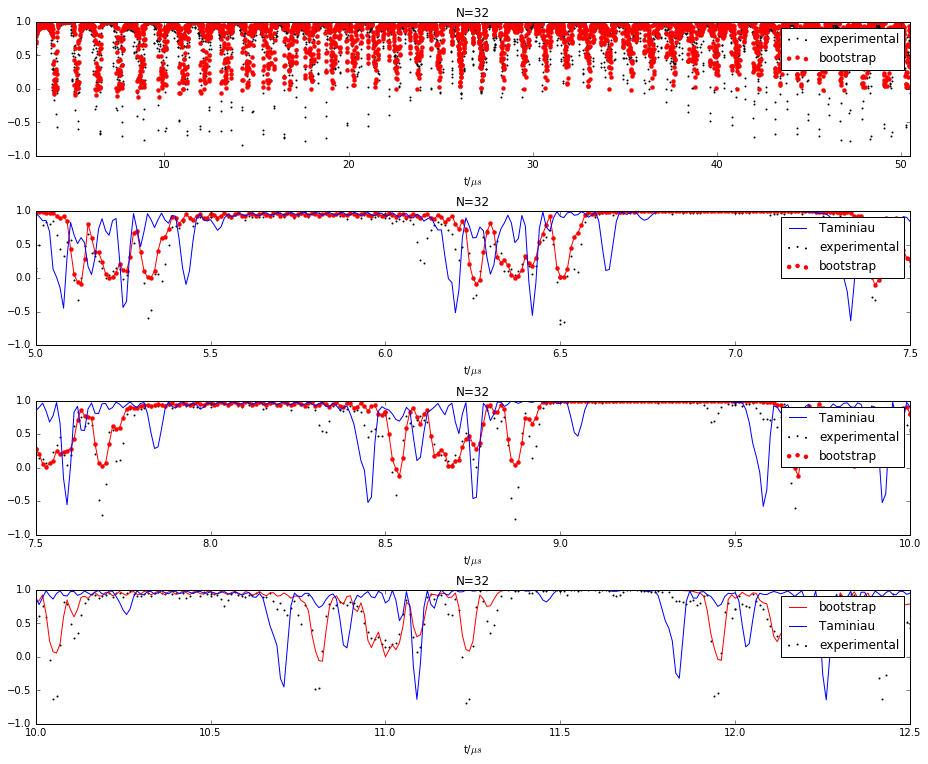

In [146]:
# Overlay it with the other fits
plt.figure(figsize=(13,8./3.*4.))
plt.subplot(4,1,1)
plt.scatter(sil18[32][:,0],sil18[32][:,1],s=1,label='experimental')
#plt.plot(sil18[32][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[32][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[32][:,0]),max(sil18[32][:,0]))
plt.ylim(-1,1)
plt.title('N=32')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(4,1,2)
plt.scatter(sil18[32][:,0],sil18[32][:,1],s=1,label='experimental')
#plt.plot(sil18[32][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[32][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[32][:,0],fitted_M,'r')
plt.plot(tau_times*10**6, tims_fit,'b',label='Delft')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=32')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(4,1,3)
plt.scatter(sil18[32][:,0],sil18[32][:,1],s=1,label='experimental')
#plt.plot(sil18[32][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[32][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[32][:,0],fitted_M,'r')
plt.plot(tau_times*10**6, tims_fit,'b',label='Delft')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=32')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(4,1,4)
plt.scatter(sil18[32][:,0],sil18[32][:,1],s=1,label='experimental')
#plt.plot(sil18[32][:,0],current_fit,'r',label='fit')
#plt.scatter(sil18[32][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[32][:,0],fitted_M,'r',label='bootstrap')
plt.plot(tau_times*10**6, tims_fit,'b',label='Delft')
plt.xlim(10,12.5)
plt.ylim(-1,1)
plt.title('N=32')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

In [147]:
# save results for N=32
pickle.dump({'N':32, 'similarity_path':similarity_path, 'fit_path':fit_path, 'chosen_spins':chosen_spins},open('fingerprint_fit_N_32_minus.pkl','wb'))

In [ ]:
# now do N = 16

In [162]:
sample = sil18[16][:,1]
tau_times = sil18[16][:,0]*10**(-6)

In [163]:
# I will now make an array which has in each row the time signature associated with the corresponding A,B values.
all_single_Ms = analysis.calc_M_single(all_spins[:,0],all_spins[:,1],16,omega_larmor,tau_times[:,None]);
all_single_Ms=all_single_Ms.transpose();

In [164]:
pickle.dump(all_single_Ms,open('all_single_Ms_min_N_16.pkl','wb'))
#all_single_Ms=pickle.load(open('all_single_Ms.pkl','rb'))

In [165]:
sample_norm = np.sqrt(sum(sample**2))
fitted_M = np.ones(len(sample))
remaining_Ms = all_single_Ms
remaining_spins = all_spins
similarity_path = []
fit_path = []
chosen_spins = []

for i in range(20):
    print('cycle='+str(i+1))
    # calculate new Ms
    the_Ms = remaining_Ms * fitted_M
    # calculate the norms
    the_Ms_norms =  np.sqrt(np.sum(the_Ms**2,axis=1))
    # calculate new similarities with experimental data
    similarities = np.dot(the_Ms,sample)/(the_Ms_norms * sample_norm)
    # find the closest one that hasn't been already been chosen
    best_spin_arg = np.argmax(similarities)
    similarity_path.append(similarities[best_spin_arg])
    # update fitted_M
    fitted_M = the_Ms[best_spin_arg]
    # update chosen_spins
    chosen_spins.append(remaining_spins[best_spin_arg])
    fit_path.append(fitted_M)
    # update remaining_Ms
    remaining_Ms = np.delete(remaining_Ms, best_spin_arg,axis=0)
    remaining_spins = np.delete(remaining_spins,best_spin_arg,axis=0)


cycle=1
cycle=2
cycle=3
cycle=4
cycle=5
cycle=6
cycle=7
cycle=8
cycle=9
cycle=10
cycle=11
cycle=12
cycle=13
cycle=14
cycle=15
cycle=16
cycle=17
cycle=18
cycle=19
cycle=20


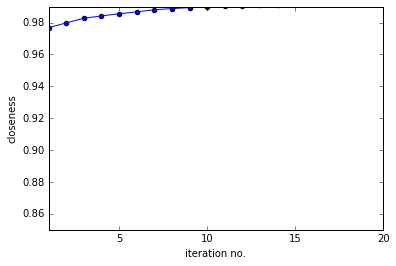

In [166]:
plt.figure()
plt.scatter(1.+np.arange(len(similarity_path)),similarity_path)
plt.plot(1.+np.arange(len(similarity_path)),similarity_path)
plt.xlabel('iteration no.')
plt.ylabel('closeness')
plt.xlim(1,20)
plt.ylim(0.85,0.99)
plt.show()

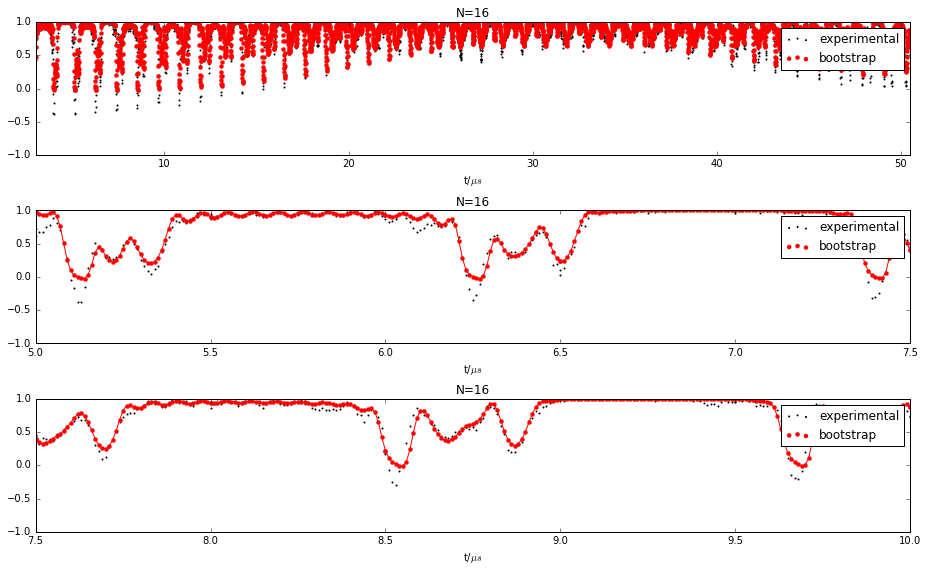

In [167]:
plt.figure(figsize=(13,8))
plt.subplot(3,1,1)
plt.scatter(sil18[16][:,0],sil18[16][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[16][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[16][:,0]),max(sil18[16][:,0]))
plt.ylim(-1,1)
plt.title('N=16')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(sil18[16][:,0],sil18[16][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[16][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[16][:,0],fitted_M,'r')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=16')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(sil18[16][:,0],sil18[16][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[16][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[16][:,0],fitted_M,'r')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=16')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

In [169]:
chosen_spins = np.array(chosen_spins)
fitted_As = chosen_spins[:,0]
fitted_Bs = chosen_spins[:,1]

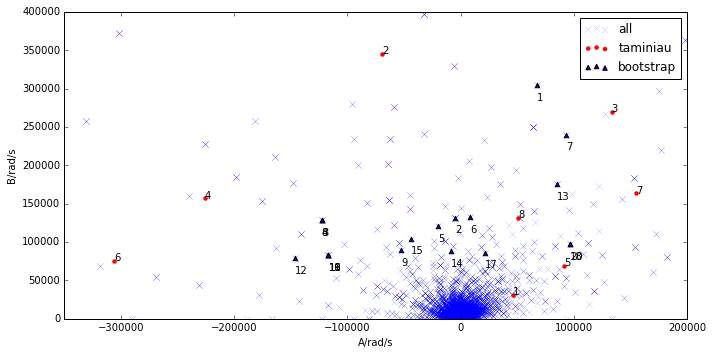

In [170]:
plt.figure(figsize=(10,5))
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1,label='all')
plt.scatter(par_params,perp_params,c='r',lw=0,label='Delft')
plt.scatter(fitted_As,fitted_Bs,marker='^',label='bootstrap')
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
for i in range(len(fitted_As)):
    plt.text(fitted_As[i],fitted_Bs[i]-20000,str(i+1))
plt.legend()
plt.tight_layout()
plt.show()

In [171]:
# Calculate M that corresponds to Taminaiu's fitted values
tims_fit=analysis.calc_M(par_params, perp_params, 16, omega_larmor, tau_times)

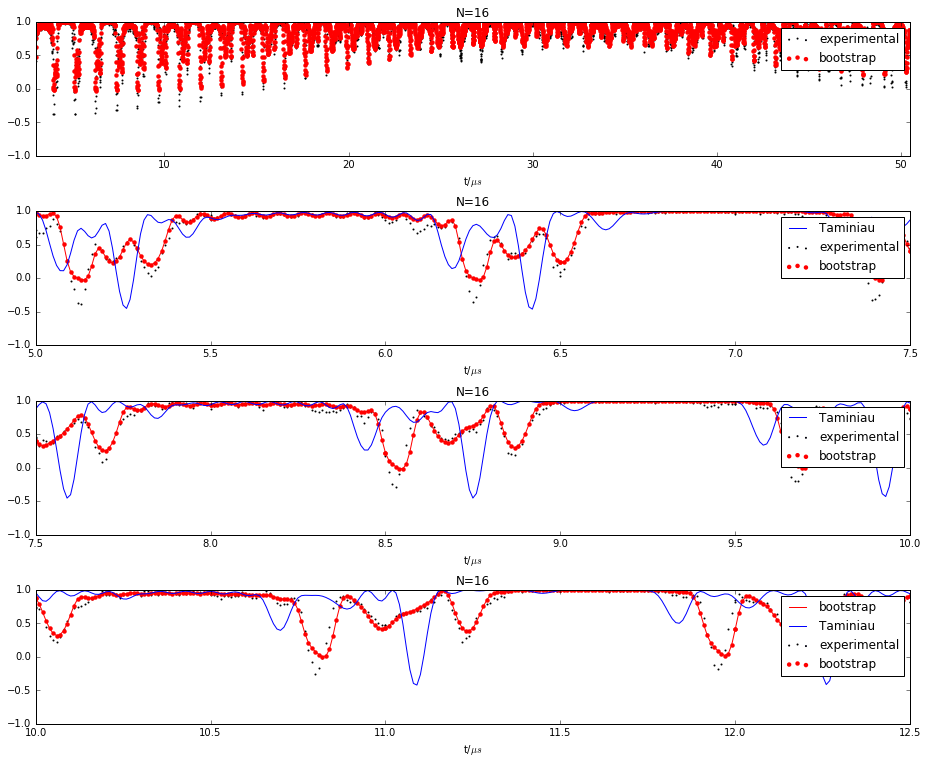

In [177]:
# Overlay it with the other fits
plt.figure(figsize=(13,8./3.*4.))
plt.subplot(4,1,1)
plt.scatter(sil18[16][:,0],sil18[16][:,1],s=1,label='experimental')
#plt.plot(sil18[16][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[16][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[16][:,0]),max(sil18[16][:,0]))
plt.ylim(-1,1)
plt.title('N=16')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(4,1,2)
plt.scatter(sil18[16][:,0],sil18[16][:,1],s=1,label='experimental')
#plt.plot(sil18[16][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[16][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[16][:,0],fitted_M,'r')
plt.plot(tau_times*10**6, tims_fit,'b',label='Delft')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=16')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(4,1,3)
plt.scatter(sil18[16][:,0],sil18[16][:,1],s=1,label='experimental')
#plt.plot(sil18[16][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[16][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[16][:,0],fitted_M,'r')
plt.plot(tau_times*10**6, tims_fit,'b',label='Delft')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=16')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(4,1,4)
plt.scatter(sil18[16][:,0],sil18[16][:,1],s=1,label='experimental')
#plt.plot(sil18[16][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[16][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[16][:,0],fitted_M,'r',label='bootstrap')
plt.plot(tau_times*10**6, tims_fit,'b',label='Delft')
plt.xlim(10,12.5)
plt.ylim(-1,1)
plt.title('N=16')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

In [173]:
# save results for N=16
pickle.dump({'N':16, 'similarity_path':similarity_path, 'fit_path':fit_path, 'chosen_spins':chosen_spins},open('fingerprint_fit_N_16_minus.pkl','wb'))

In [187]:
# now do N = 8

In [188]:
sample = sil18[8][:,1]
tau_times = sil18[8][:,0]*10**(-6)

In [189]:
# I will now make an array which has in each row the time signature associated with the corresponding A,B values.
all_single_Ms = analysis.calc_M_single(all_spins[:,0],all_spins[:,1],8,omega_larmor,tau_times[:,None]);
all_single_Ms=all_single_Ms.transpose();

In [190]:
pickle.dump(all_single_Ms,open('all_single_Ms_min_N_8.pkl','wb'))
#all_single_Ms=pickle.load(open('all_single_Ms.pkl','rb'))

In [191]:
sample_norm = np.sqrt(sum(sample**2))
fitted_M = np.ones(len(sample))
remaining_Ms = all_single_Ms
remaining_spins = all_spins
similarity_path = []
fit_path = []
chosen_spins = []

for i in range(20):
    print('cycle='+str(i+1))
    # calculate new Ms
    the_Ms = remaining_Ms * fitted_M
    # calculate the norms
    the_Ms_norms =  np.sqrt(np.sum(the_Ms**2,axis=1))
    # calculate new similarities with experimental data
    similarities = np.dot(the_Ms,sample)/(the_Ms_norms * sample_norm)
    # find the closest one that hasn't been already been chosen
    best_spin_arg = np.argmax(similarities)
    similarity_path.append(similarities[best_spin_arg])
    # update fitted_M
    fitted_M = the_Ms[best_spin_arg]
    # update chosen_spins
    chosen_spins.append(remaining_spins[best_spin_arg])
    fit_path.append(fitted_M)
    # update remaining_Ms
    remaining_Ms = np.delete(remaining_Ms, best_spin_arg,axis=0)
    remaining_spins = np.delete(remaining_spins,best_spin_arg,axis=0)


cycle=1
cycle=2
cycle=3
cycle=4
cycle=5
cycle=6
cycle=7
cycle=8
cycle=9
cycle=10
cycle=11
cycle=12
cycle=13
cycle=14
cycle=15
cycle=16
cycle=17
cycle=18
cycle=19
cycle=20


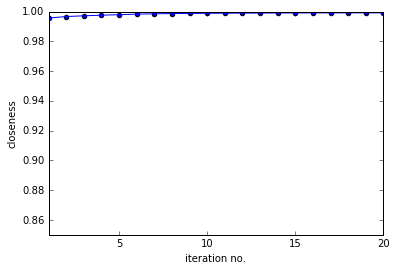

In [193]:
plt.figure()
plt.scatter(1.+np.arange(len(similarity_path)),similarity_path)
plt.plot(1.+np.arange(len(similarity_path)),similarity_path)
plt.xlabel('iteration no.')
plt.ylabel('closeness')
plt.xlim(1,20)
plt.ylim(0.85,1)
plt.show()

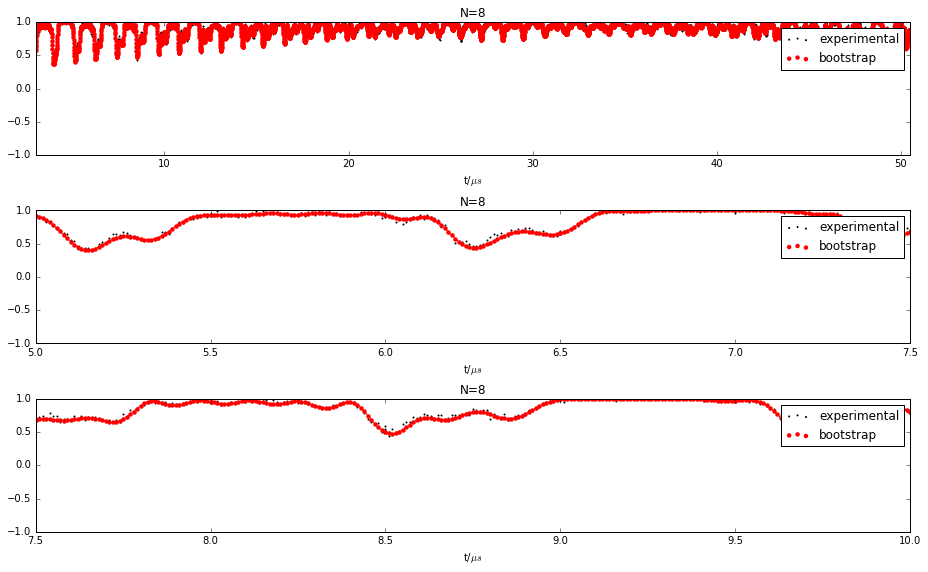

In [194]:
plt.figure(figsize=(13,8))
plt.subplot(3,1,1)
plt.scatter(sil18[8][:,0],sil18[8][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[8][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[8][:,0]),max(sil18[8][:,0]))
plt.ylim(-1,1)
plt.title('N=8')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(sil18[8][:,0],sil18[8][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[8][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[8][:,0],fitted_M,'r')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=8')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(sil18[8][:,0],sil18[8][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[8][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[8][:,0],fitted_M,'r')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=8')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

In [195]:
chosen_spins = np.array(chosen_spins)
fitted_As = chosen_spins[:,0]
fitted_Bs = chosen_spins[:,1]

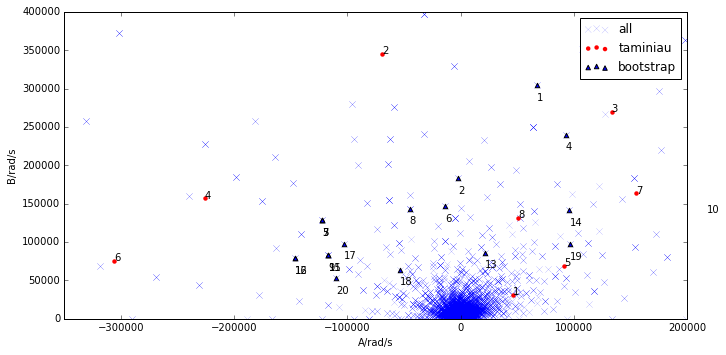

In [196]:
plt.figure(figsize=(10,5))
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1,label='all')
plt.scatter(par_params,perp_params,c='r',lw=0,label='Delft')
plt.scatter(fitted_As,fitted_Bs,marker='^',label='bootstrap')
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
for i in range(len(fitted_As)):
    plt.text(fitted_As[i],fitted_Bs[i]-20000,str(i+1))
plt.legend()
plt.tight_layout()
plt.show()

In [197]:
# Calculate M that corresponds to Taminaiu's fitted values
tims_fit=analysis.calc_M(par_params, perp_params, 8, omega_larmor, tau_times)

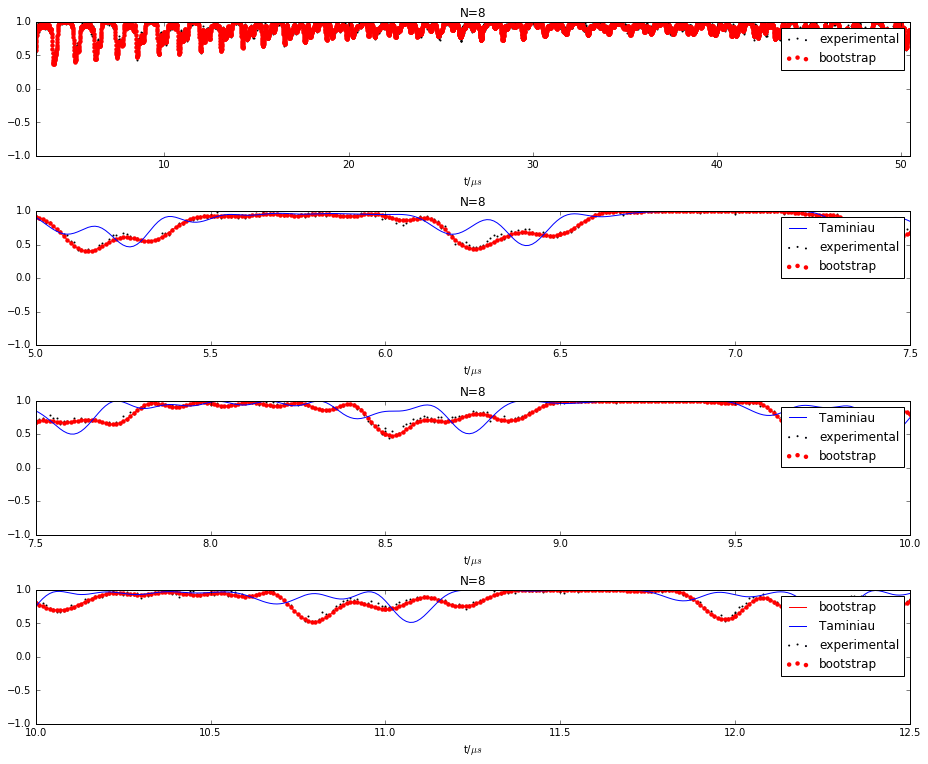

In [198]:
# Overlay it with the other fits
plt.figure(figsize=(13,8./3.*4.))
plt.subplot(4,1,1)
plt.scatter(sil18[8][:,0],sil18[8][:,1],s=1,label='experimental')
#plt.plot(sil18[8][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[8][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[8][:,0]),max(sil18[8][:,0]))
plt.ylim(-1,1)
plt.title('N=8')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(4,1,2)
plt.scatter(sil18[8][:,0],sil18[8][:,1],s=1,label='experimental')
#plt.plot(sil18[8][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[8][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[8][:,0],fitted_M,'r')
plt.plot(tau_times*10**6, tims_fit,'b',label='Delft')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=8')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(4,1,3)
plt.scatter(sil18[8][:,0],sil18[8][:,1],s=1,label='experimental')
#plt.plot(sil18[8][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[8][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[8][:,0],fitted_M,'r')
plt.plot(tau_times*10**6, tims_fit,'b',label='Delft')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=8')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(4,1,4)
plt.scatter(sil18[8][:,0],sil18[8][:,1],s=1,label='experimental')
#plt.plot(sil18[8][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[8][:,0],fitted_M,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[8][:,0],fitted_M,'r',label='bootstrap')
plt.plot(tau_times*10**6, tims_fit,'b',label='Delft')
plt.xlim(10,12.5)
plt.ylim(-1,1)
plt.title('N=8')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

In [199]:
# save results for N=8
pickle.dump({'N':8, 'similarity_path':similarity_path, 'fit_path':fit_path, 'chosen_spins':chosen_spins},open('fingerprint_fit_N_8_minus.pkl','wb'))

In [200]:
full_results = {}
full_results[8] = pickle.load(open('fingerprint_fit_N_8_minus.pkl'))
full_results[16] = pickle.load(open('fingerprint_fit_N_16_minus.pkl'))
full_results[32] = pickle.load(open('fingerprint_fit_N_32_minus.pkl'))
full_results[64] = pickle.load(open('fingerprint_fit_N_64_minus.pkl'))

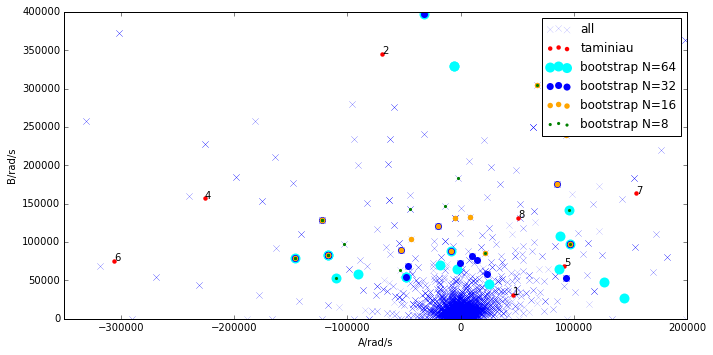

In [307]:
plt.figure(figsize=(10,5))
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1,label='all')
plt.scatter(par_params,perp_params,c='r',lw=0,label='Delft')
plt.scatter(full_results[64]['chosen_spins'][:,0],full_results[64]['chosen_spins'][:,1],marker='o',label='bootstrap N=64',c='cyan',s=100,lw=0)
plt.scatter(full_results[32]['chosen_spins'][:,0],full_results[32]['chosen_spins'][:,1],marker='o',label='bootstrap N=32',s=50,lw=0)
plt.scatter(full_results[16]['chosen_spins'][:,0],full_results[16]['chosen_spins'][:,1],marker='o',label='bootstrap N=16',c='orange',lw=0,s=30)
plt.scatter(full_results[8]['chosen_spins'][:,0],full_results[8]['chosen_spins'][:,1],marker='o',label='bootstrap N=8',c='green',lw=0,s=10)

plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
plt.legend()
plt.tight_layout()
#plt.savefig('/Users/juan/Google Drive/Zia Lab/Log/Graphs/plot1497397429.pdf')
#plt.savefig('/Users/juan/Google Drive/Zia Lab/Log/Graphs/plot1497397429.png',dpi=300)
plt.show()

In [ ]:
# Of the spins that were fit at the end, how many were close fits in the first iteration?

In [ ]:
# do analysis for N = 32

In [207]:
sample = sil18[32][:,1]
tau_times = sil18[32][:,0]*10**(-6)

In [206]:
# I will now make an array which has in each row the time signature associated with the corresponding A,B values.
all_single_Ms = analysis.calc_M_single(all_spins[:,0],all_spins[:,1],32,omega_larmor,tau_times[:,None]);
all_single_Ms=all_single_Ms.transpose();

In [208]:
# load the previously calculated results for N=32
results32 = pickle.load(open('fingerprint_fit_N_32_minus.pkl'))

In [211]:
sample_norm = np.sqrt(sum(sample**2))
fitted_M = np.ones(len(sample))
remaining_Ms = all_single_Ms
remaining_spins = all_spins
similarity_path = []
fit_path = []
chosen_spins = []

for i in range(1):
    print('cycle='+str(i+1))
    # calculate new Ms
    the_Ms = remaining_Ms * fitted_M
    # calculate the norms
    the_Ms_norms =  np.sqrt(np.sum(the_Ms**2,axis=1))
    # calculate new similarities with experimental data
    similarities = np.dot(the_Ms,sample)/(the_Ms_norms * sample_norm)
    # find the closest one that hasn't been already been chosen
    best_spin_arg = np.argmax(similarities)
    similarity_path.append(similarities[best_spin_arg])
    # update fitted_M
    fitted_M = the_Ms[best_spin_arg]
    # update chosen_spins
    chosen_spins.append(remaining_spins[best_spin_arg])
    fit_path.append(fitted_M)
    # update remaining_Ms
    remaining_Ms = np.delete(remaining_Ms, best_spin_arg,axis=0)
    remaining_spins = np.delete(remaining_spins,best_spin_arg,axis=0)


cycle=1


In [233]:
sorted_similarities =  np.sort(similarities)
#sorted_similarities = list(sorted_similarities)
sorted_spins = list(list(x) for x in all_spins[np.argsort(similarities)])

In [237]:
len(sorted_similarities)

9879

In [238]:
len(sorted_spins)

9879

In [239]:
spins32 = list(list(x) for x in results32['chosen_spins'])
for found_spin in spins32:
    #print(found_spin)
    print(len(sorted_spins)-sorted_spins.index(found_spin)-1)

1
6
9
23
30
37
107
25
48
28
24
34
183
137
54
22
49
332
155
181


CONCLUSION: spins that are eventually selected were initially also very similar in the first iteration

In [242]:
# Make a correct plot of the fitted result from Delft
# for N=32
delft32 =  pickle.load(open('/Users/juan/Downloads/fitting_fingerprints/min32.pkl','rb'))

In [270]:
len(delft32['M'])

8

In [271]:
# calculate the total M
total32 = np.ones(len(delft32['M'][0]))
for i in range(len(delft32['M'])):
    total32 *= delft32['M'][i]

In [282]:
 full_results[32]['fit_path'][-1]

array([ 0.81341813,  0.68004922,  0.7100274 , ...,  0.93240245,
        0.64068729,  0.33031718])

In [311]:
(delft32['taus'][1]-delft32['taus'][0])*10**6

0.0072007200720072013

In [312]:
(tau_times[1]-tau_times[0])*10**6

0.0099999999999994815

In [315]:
tau_times[-1]

5.0500000000000001e-05

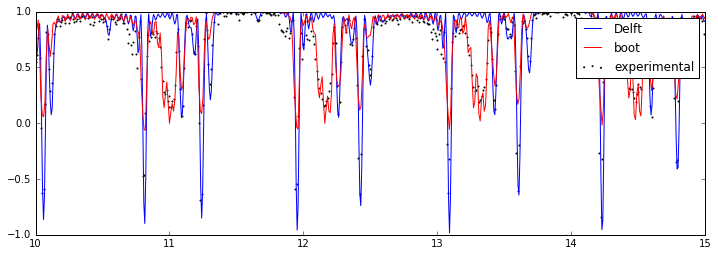

In [320]:
plt.figure(figsize=(12,4))
#plt.scatter(delft32['taus']*10**6,delft32['M'][2,:])
#plt.plot(delft32['taus']*10**6,delft32['M'][2,:])
plt.plot(delft32['taus']*10**6,total32,label='Delft')
plt.scatter(sil18[32][:,0],sil18[32][:,1],s=1,label='experimental')
#plt.plot( tau_times*10**6 ,tims_fit,label='Delft - calculated')
plt.plot( tau_times*10**6,  full_results[32]['fit_path'][-1],label='boot',c='r')
plt.legend()
plt.xlim(10,15)
plt.ylim(-1,1)
plt.show()

### Implement a binary fit tree 15-Jun-2017

In [339]:
# code generator
depth = 4
nestedfors = ''
for counter in range(depth):
    nestedfors += 'for counter' + str(counter) + ' in range(1)'+':\n'
    nestedfors += ' '*4*(counter+1)
    # put in the code that select the two most similar spins
print(nestedfors)

for counter0 in range(1):
    for counter1 in range(1):
        for counter2 in range(1):
            for counter3 in range(1):
                


In [367]:
# gave up on this approach
# it will run faster than the alternative
# below, but it will take lots of memory.

def singM(spin):
    return np.array([0.5,0.5])

superM = {} # This dictionary will contain the fitted M at every node.
superS = {} # This will contain the spins at every node.
seedM = np.ones(len(sample)) # This is the seed from which every M stems
seedS = [] # Initially there are no spins whatsoever

for counter0 in range(2):
    
    superM[counter0] = seedM *  singM(counter0)
    superS[counter0] = seedS + [counter0]
    
    # calculate new Ms
    the_Ms = remaining_Ms * fitted_M
    
    # calculate the norms
    the_Ms_norms =  np.sqrt(np.sum(the_Ms**2,axis=1))
    # calculate new similarities with experimental data
    similarities = np.dot(the_Ms,sample)/(the_Ms_norms * sample_norm)
    # find the closest one that hasn't been already been chosen
    best_spin_arg = np.argmax(similarities)
    similarity_path.append(similarities[best_spin_arg])
    # update fitted_M
    fitted_M = the_Ms[best_spin_arg]
    # update chosen_spins
    chosen_spins.append(remaining_spins[best_spin_arg])
    fit_path.append(fitted_M)
    # update remaining_Ms
    remaining_Ms = np.delete(remaining_Ms, best_spin_arg,axis=0)
    remaining_spins = np.delete(remaining_spins,best_spin_arg,axis=0)    
    
    for counter1 in range(2):
        superM[counter0, counter1] = superM[counter0] * singM(counter1)
        superS[counter0, counter1] = superS[counter0] + [counter1]
        
        
#         for counter2 in range(2):
#             superM[counter0, counter1,counter2] = superM[counter0,counter1] * singM(counter2)
#             superS[counter0, counter1,counter2] = superS[counter0,counter1] + [counter2]
#             for counter3 in range(2):
#                 superM[counter0, counter1,counter2,counter3] = superM[counter0,counter1,counter2] * singM(counter3)
#                 superS[counter0, counter1,counter2,counter3] = superS[counter0,counter1,counter2] + [counter3]
#                 #print(counter0,counter1,counter2,counter3)
#                 #print(superM)

In [364]:
superS[0,1,0,1]

[0, 1, 0, 1]

In [369]:
import itertools
roads = list(itertools.product([0, 1], repeat=4))

In [376]:
np.argsort(np.random.random(10))[-2]

3

In [403]:
# I will now make an array which has in each row the time signature associated with the corresponding A,B values.
all_single_Ms = analysis.calc_M_single(all_spins[:,0],all_spins[:,1],32,omega_larmor,tau_times[:,None]);
all_single_Ms=all_single_Ms.transpose();

In [424]:
np.argsort(similarities)[-4]

377

In [440]:
np.sqrt(all_spins[:,0]**2+all_spins[:,1]**2)

array([ 11414.09195339,  11414.09195339,   5370.41637862, ...,
        22718.97297536,   3762.92192788,   9915.63873916])

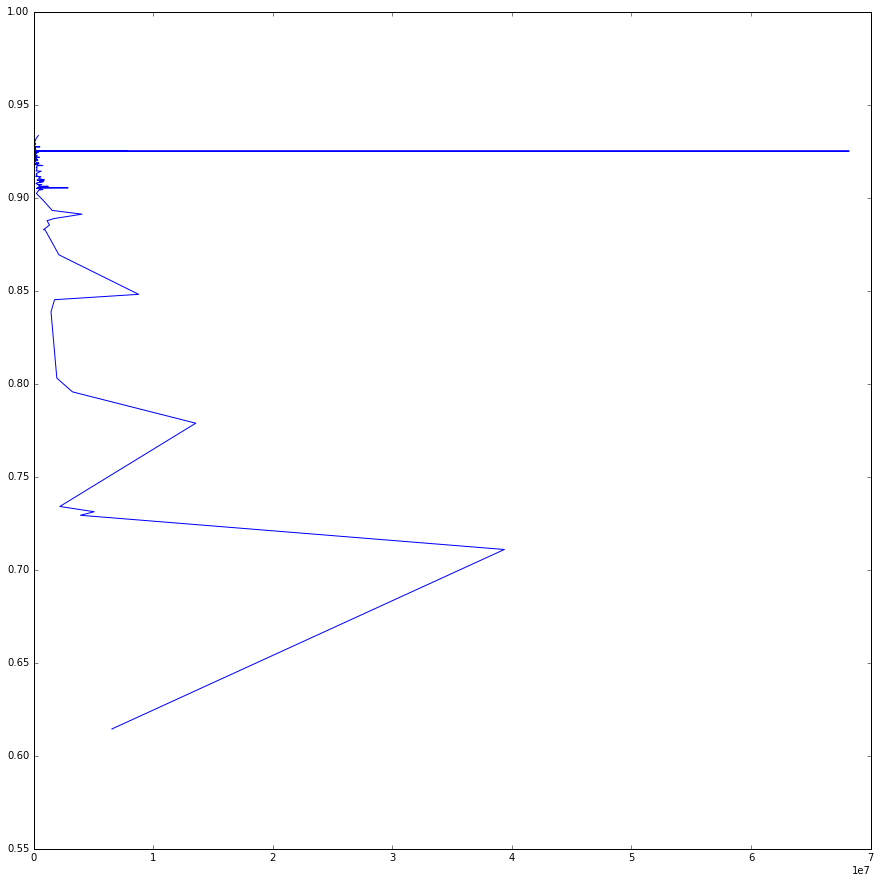

In [449]:
plt.figure(figsize=(15,15))
plt.plot(np.sqrt(all_spins[np.argsort(similarities)][:,0]**2+all_spins[np.argsort(similarities)][:,1]**2),similarities[np.argsort(similarities)])
plt.ylim(0.55,1)
plt.show()

In [481]:
sample_norm = np.sqrt(sum(sample**2))
counter1497542609 = 0
finalspins = {}
finalM = {}
finalSimilarity = {}
num_cycles = 6
roads = list(itertools.product([0, 1], repeat=num_cycles))


for road in roads:

    fitted_M = np.ones(len(sample))
    remaining_Ms = all_single_Ms
    remaining_spins = all_spins
    similarity_path = []
    fit_path = []
    chosen_spins = []
    print(road)
    
    for i in range(num_cycles):
        leftorright = road[i]
        #print('cycle='+str(i+1))
        # calculate new Ms
        the_Ms = remaining_Ms * fitted_M
        # calculate the norms
        the_Ms_norms =  np.sqrt(np.sum(the_Ms**2,axis=1))
        # calculate new similarities with experimental data
        similarities = np.dot(the_Ms,sample)/(the_Ms_norms * sample_norm)
        # find the closest one that hasn't been already been chosen
        if leftorright == 0:
            best_spin_arg = np.argmax(similarities)
        else:
            best_spin_arg = np.argsort(similarities)[-2]
        similarity_path.append(similarities[best_spin_arg])
        # update fitted_M
        fitted_M = the_Ms[best_spin_arg]
        # update chosen_spins
        chosen_spins.append(remaining_spins[best_spin_arg])
        fit_path.append(fitted_M)
        # update remaining_Ms
        
        if i == 0:
            remaining_spins = remaining_spins[np.argsort(similarities)][-400:]
            remaining_Ms = remaining_Ms[np.argsort(similarities)][-400:]
            if leftorright == 0:
                remaining_spins = np.delete(remaining_spins,-1,axis=0)
                remaining_Ms = np.delete(remaining_Ms, -1,axis=0)
            else:
                remaining_spins = np.delete(remaining_spins,-2,axis=0)
                remaining_Ms = np.delete(remaining_Ms, -2,axis=0)
        else:
            remaining_spins = np.delete(remaining_spins,best_spin_arg,axis=0)
            remaining_Ms = np.delete(remaining_Ms, best_spin_arg,axis=0)
    
    finalspins[road] = chosen_spins
    finalM[road] = fitted_M
    finalSimilarity[road] = similarity_path[-1]

(0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 1)
(0, 0, 0, 0, 1, 0)
(0, 0, 0, 0, 1, 1)
(0, 0, 0, 1, 0, 0)
(0, 0, 0, 1, 0, 1)
(0, 0, 0, 1, 1, 0)
(0, 0, 0, 1, 1, 1)
(0, 0, 1, 0, 0, 0)
(0, 0, 1, 0, 0, 1)
(0, 0, 1, 0, 1, 0)
(0, 0, 1, 0, 1, 1)
(0, 0, 1, 1, 0, 0)
(0, 0, 1, 1, 0, 1)
(0, 0, 1, 1, 1, 0)
(0, 0, 1, 1, 1, 1)
(0, 1, 0, 0, 0, 0)
(0, 1, 0, 0, 0, 1)
(0, 1, 0, 0, 1, 0)
(0, 1, 0, 0, 1, 1)
(0, 1, 0, 1, 0, 0)
(0, 1, 0, 1, 0, 1)
(0, 1, 0, 1, 1, 0)
(0, 1, 0, 1, 1, 1)
(0, 1, 1, 0, 0, 0)
(0, 1, 1, 0, 0, 1)
(0, 1, 1, 0, 1, 0)
(0, 1, 1, 0, 1, 1)
(0, 1, 1, 1, 0, 0)
(0, 1, 1, 1, 0, 1)
(0, 1, 1, 1, 1, 0)
(0, 1, 1, 1, 1, 1)
(1, 0, 0, 0, 0, 0)
(1, 0, 0, 0, 0, 1)
(1, 0, 0, 0, 1, 0)
(1, 0, 0, 0, 1, 1)
(1, 0, 0, 1, 0, 0)
(1, 0, 0, 1, 0, 1)
(1, 0, 0, 1, 1, 0)
(1, 0, 0, 1, 1, 1)
(1, 0, 1, 0, 0, 0)
(1, 0, 1, 0, 0, 1)
(1, 0, 1, 0, 1, 0)
(1, 0, 1, 0, 1, 1)
(1, 0, 1, 1, 0, 0)
(1, 0, 1, 1, 0, 1)
(1, 0, 1, 1, 1, 0)
(1, 0, 1, 1, 1, 1)
(1, 1, 0, 0, 0, 0)
(1, 1, 0, 0, 0, 1)
(1, 1, 0, 0, 1, 0)
(1, 1, 0, 0, 1, 1)
(1, 1, 0, 1,

In [482]:
finalM

{(0,
  0,
  0,
  0,
  0,
  0): array([ 0.92950627,  0.78723402,  0.77799473, ...,  0.94922582,
         0.66360278,  0.3429683 ]),
 (0,
  0,
  0,
  0,
  0,
  1): array([ 0.92950627,  0.78723402,  0.77799473, ...,  0.94922582,
         0.66360278,  0.3429683 ]),
 (0,
  0,
  0,
  0,
  1,
  0): array([ 0.92950627,  0.78723402,  0.77799473, ...,  0.94922582,
         0.66360278,  0.3429683 ]),
 (0,
  0,
  0,
  0,
  1,
  1): array([ 0.92950627,  0.78723402,  0.77799473, ...,  0.94922582,
         0.66360278,  0.3429683 ]),
 (0,
  0,
  0,
  1,
  0,
  0): array([ 0.92950627,  0.78723402,  0.77799473, ...,  0.94922582,
         0.66360278,  0.3429683 ]),
 (0,
  0,
  0,
  1,
  0,
  1): array([ 0.92950627,  0.78723402,  0.77799473, ...,  0.94922582,
         0.66360278,  0.3429683 ]),
 (0,
  0,
  0,
  1,
  1,
  0): array([ 0.92950627,  0.78723402,  0.77799473, ...,  0.94922582,
         0.66360278,  0.3429683 ]),
 (0,
  0,
  0,
  1,
  1,
  1): array([ 0.92950627,  0.78723402,  0.77799473, ...,  

In [483]:
finals=[finalSimilarity[key] for key in finalSimilarity];

In [485]:
min(finals)

0.95550100133712423

In [486]:
max(finals)

0.95550100133712657

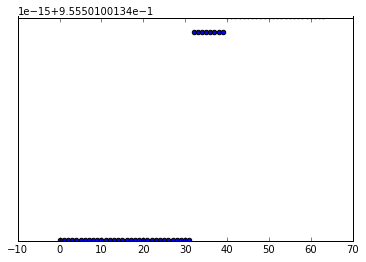

In [484]:
plt.figure()
plt.scatter(np.arange(len(finals)),np.sort(finals))
plt.ylim(min(finals),max(finals))
plt.show()

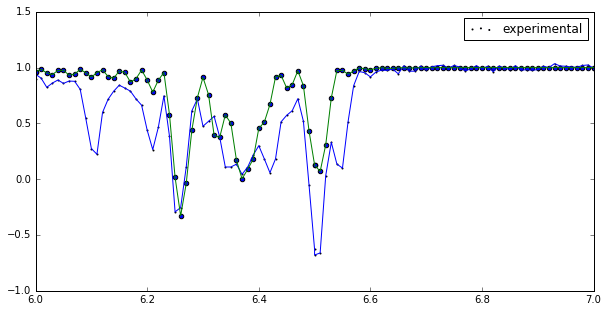

In [492]:
plt.figure(figsize=(10,5))
# for key in finalM.keys():
#     plt.scatter(tau_times*10**6, finalM[key], s=1,)
#     plt.plot(tau_times*10**6, finalM[key])
plt.scatter(sil18[32][:,0],sil18[32][:,1],s=1,label='experimental')
plt.plot(sil18[32][:,0],sil18[32][:,1])
plt.scatter(tau_times * 10**6, finalM[(0,0,0,0,0,0)])
plt.plot(tau_times * 10**6, finalM[(1,1,1,1,1,1)])
#plt.plot( tau_times*10**6 ,tims_fit,label='Delft - calculated')
plt.legend()
plt.xlim(6,7)
plt.show()

In [502]:
self_similarities = np.corrcoef(all_single_Ms);

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [503]:
np.shape(self_similarities)

(9879, 9879)

In [504]:
self_similarities = self_similarities.flatten();

In [509]:
self_similarities=self_similarities[~np.isnan(self_similarities)]

In [510]:
min(self_similarities)

-0.13655422990832747

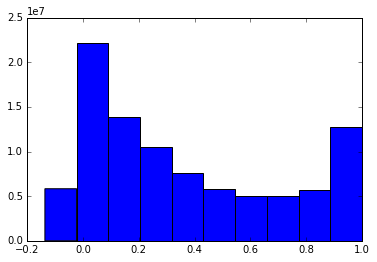

In [511]:
plt.figure()
plt.hist(self_similarities)
plt.show()

In conclusion, there's slight to no variation between the several fitting paths followed. Also, as the covariance matrix shows, there's also a significant variation between the individual M signals.

## No. 1 SIL 18

In [12]:
def closeness(x,y):
    return sum(x*y)/(np.sqrt(sum(x**2))*np.sqrt(sum(y**2)))

In [91]:
all_spins = 2*np.pi*1000 * np.genfromtxt('complete_lattice.csv', delimiter=',') # imported in Hz
all_spins[:,1] = np.abs(all_spins[:,1])

In [92]:
# taken from /Users/juan/Downloads/fitting_fingerprints/fitting_fingerprints/hyperfine_params.py
hyperfine_params = {} # I'm assuming that these come in Hz
hyperfine_params['C1']  = {'par' : -36.0e3, 'perp':25.0e3}
hyperfine_params['C2']  = {'par' : 21.2e3, 'perp':43.0e3}
hyperfine_params['C3']  = {'par' : -11.0e3, 'perp':55.0e3}
hyperfine_params['C4']  = {'par' : 8.1e3, 'perp':21.0e3}
hyperfine_params['C5']  = {'par' : 24.7e3, 'perp':26.0e3}
hyperfine_params['C6']  = {'par' : -48.7e3, 'perp':12.0e3}
hyperfine_params['C7']  = {'par' : 14.5e3, 'perp':11.0e3}
# hyperfine_params['C8']  = {'par' : -20.5e3, 'perp':21.0e3}
hyperfine_params['C8']  = {'par' : 7.32e3, 'perp':5.0e3}

In [93]:
par_params = []
perp_params = []
for llave in hyperfine_params.keys(): # convert to rad/s
    par_params.append(2.*np.pi*hyperfine_params[llave]['par'])
    perp_params.append(2.*np.pi*hyperfine_params[llave]['perp'])

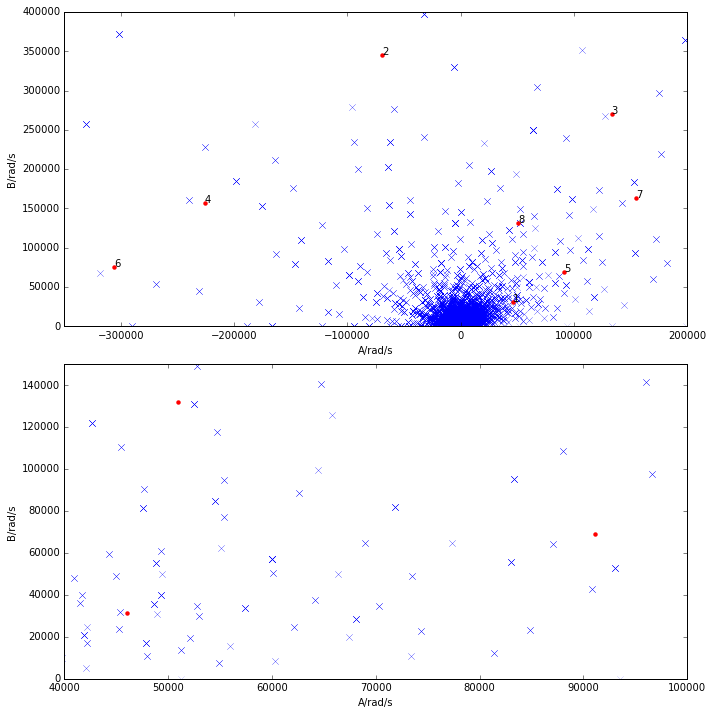

In [109]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1)
plt.scatter(par_params,perp_params,c='r',lw=0)
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
plt.subplot(2,1,2)
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1)
plt.scatter(par_params,perp_params,c='r',lw=0)
plt.xlim(40000,100000)
plt.ylim(0,150000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
plt.tight_layout()
plt.show()

In [119]:
sil18={}
magic_Ns=[4,8,16,32,64]
for num in magic_Ns:
    sil18[num] = np.transpose(np.loadtxt('/Users/juan/Downloads/fitting_fingerprints/sil18_fingerprint_ms_plus_N'+str(num)+'.txt'))

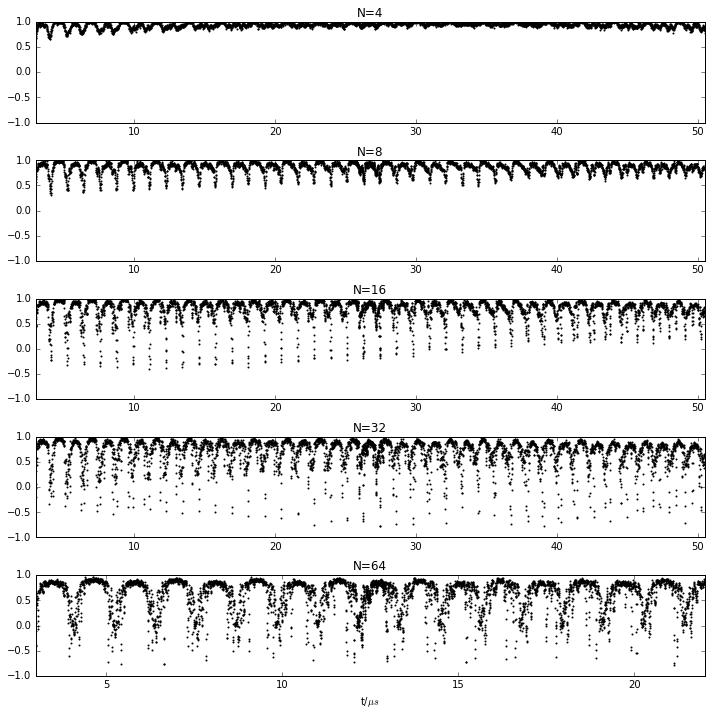

In [130]:
plt.figure(figsize=(10,10))
for counter in range(len(magic_Ns)):
    plt.subplot(len(magic_Ns),1,counter+1)
    this_magic_N=magic_Ns[counter]
    plt.scatter(sil18[this_magic_N][:,0],sil18[this_magic_N][:,1],s=1)
    plt.xlim(min(sil18[this_magic_N][:,0]),max(sil18[this_magic_N][:,0]))
    plt.ylim(-1,1)
    plt.title('N='+str(this_magic_N))
plt.xlabel('t/$\mu s$')
plt.tight_layout()
plt.show()

## Try the bootstrap fit

### N = 64

In [137]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import time
import os,sys,inspect
import pickle
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1. * ms * gam_c * B_field

In [139]:
def closeness(x,y):
    return sum(x*y)/(np.sqrt(sum(x**2))*np.sqrt(sum(y**2)))

In [147]:
sample = sil18[64][:,1]
tau_times = sil18[64][:,0]*10**(-6)

In [149]:
# In here the bootstrap is applied.
# Each round takes about 80s.
#%%time
current_fit = np.ones(len(sample))
fitted_As=[]
fitted_Bs=[]
remaining_spins = np.copy(all_spins)
counter_3 = 0
path_followed = []
best_resemblance = 0.
for counter_1 in range(20):
    closenesses=[]
    print("round "+str(counter_1))
    for counter_2 in range(len(remaining_spins)):
        AB = remaining_spins[counter_2] # Select the spin to be considered.
#         if (counter_2 % 200 == 0 and counter_1 > 0) or (counter_2 % 1000 == 0 and counter_1 == 0):
#             frac = int(float(counter_2)/len(remaining_spins)*100.)
#             print(frac),
        ansatz = current_fit * analysis.calc_M_single(AB[0],AB[1],64, omega_larmor,tau_times) # calculate the signal that would result if the new spin was added to it
        closenesses.append(closeness(ansatz, sample)) # append the resulting closeness to the list that stores them all
    max_closenesses_index = np.argmax(closenesses) # Find the index for the spin that gave the greater similarity
    best_resemblance = closenesses[max_closenesses_index]
    if closenesses[max_closenesses_index] >= best_resemblance:
        print('Going uphill')
    else:
        print('Going downhill')
    best_A = remaining_spins[max_closenesses_index][0]
    best_B = remaining_spins[max_closenesses_index][1]
    print("best = "+str(best_resemblance))
    path_followed.append(best_resemblance) # Append the best closeness
    fitted_As.append(remaining_spins[max_closenesses_index][0]) # Append the best A
    fitted_Bs.append(remaining_spins[max_closenesses_index][1]) # Append the best B
    current_fit = current_fit * analysis.calc_M_single(best_A,best_B,64, omega_larmor,tau_times) # Calculate the updated fit for M
    if False and (counter_1 == 0): # Enable this to eliminate most spins on end of firs iteration. This was not enabled for the plot showed in the report.
        remaining_spins = remaining_spins[np.argsort(closenesses)[-5000:]]
    else:
        remaining_spins=np.delete(remaining_spins,max_closenesses_index,axis=0) # Eliminate the best spin from the set of possible options.

round 0
Going uphill
best = 0.88639566388
round 1
Going uphill
best = 0.900352896953
round 2
Going uphill
best = 0.912027964038
round 3
Going uphill
best = 0.920370088124
round 4
Going uphill
best = 0.927510740301
round 5
Going uphill
best = 0.933296188425
round 6
Going uphill
best = 0.937083974706
round 7
Going uphill
best = 0.94070040039
round 8
Going uphill
best = 0.94331887148
round 9
Going uphill
best = 0.945156533952
round 10
Going uphill
best = 0.946808357608
round 11
Going uphill
best = 0.94833892325
round 12
Going uphill
best = 0.949580698916
round 13
Going uphill
best = 0.950747615383
round 14
Going uphill
best = 0.951910732193
round 15
Going uphill
best = 0.952991808083
round 16
Going uphill
best = 0.953822586097
round 17
Going uphill
best = 0.954562402668
round 18
Going uphill
best = 0.955307373738
round 19
Going uphill
best = 0.956039585092


In [ ]:
pickle.dump({'tauN':64,fitted_As':fitted_As,'fitted_Bs':fitted_Bs})

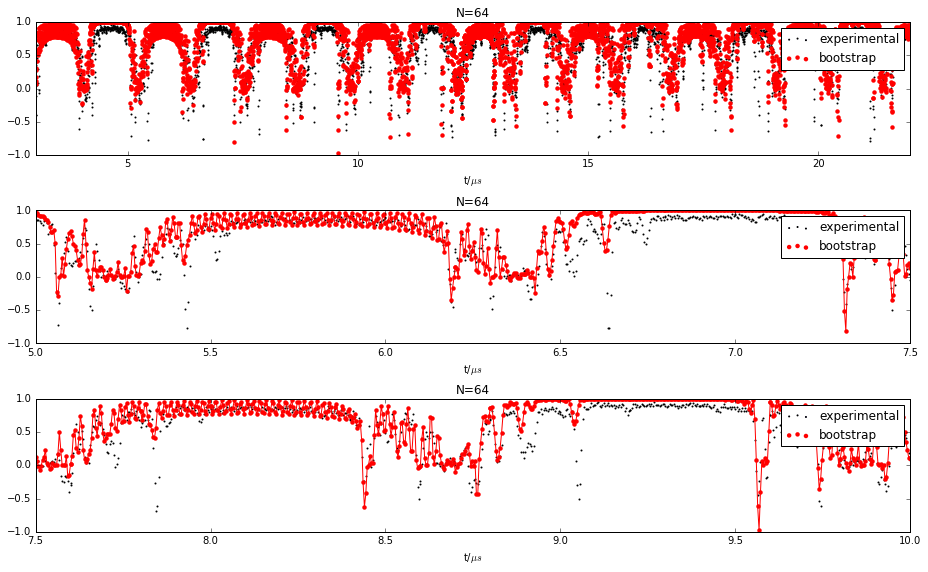

In [182]:
plt.figure(figsize=(13,8))
plt.subplot(3,1,1)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[64][:,0]),max(sil18[64][:,0]))
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],current_fit,'r')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],current_fit,'r')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

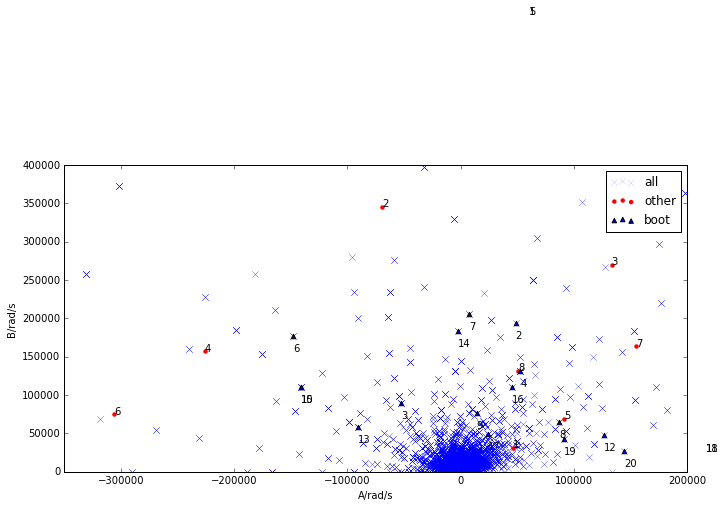

In [194]:
plt.figure(figsize=(10,5))
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1,label='all')
plt.scatter(par_params,perp_params,c='r',lw=0,label='other')
plt.scatter(fitted_As,fitted_Bs,marker='^',label='boot')
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
for i in range(len(fitted_As)):
    plt.text(fitted_As[i],fitted_Bs[i]-20000,str(i+1))
plt.legend()
plt.tight_layout()
plt.show()

### N = 64 (optimized)

In [195]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import time
import os,sys,inspect
import pickle
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1. * ms * gam_c * B_field

In [197]:
def closeness(x,y):
    return sum(x*y)/(np.sqrt(sum(x**2))*np.sqrt(sum(y**2)))

In [147]:
sample = sil18[64][:,1]
tau_times = sil18[64][:,0]*10**(-6)

In [214]:
all_single_Ms = []
for counter_2 in range(len(all_spins)):
    AB = all_spins[counter_2] # Select the spin to be considered.
    all_single_Ms.append(analysis.calc_M_single(AB[0],AB[1],64, omega_larmor,tau_times)) # calculate the signal that would result if the new spin was added to it
    #closenesses.append(closeness(ansatz, sample)) # append the resulting closeness to the list that stores them all

In [211]:
9.16 * 10**(-3) * len(all_spins)

307.15312

In [149]:
# In here the bootstrap is applied.
# Each round takes about 80s.
#%%time
current_fit = np.ones(len(sample))
fitted_As=[]
fitted_Bs=[]
remaining_spins = np.copy(all_spins)
counter_3 = 0
path_followed = []
best_resemblance = 0.
for counter_1 in range(20):
    closenesses=[]
    print("round "+str(counter_1))
    for counter_2 in range(len(remaining_spins)):
        AB = remaining_spins[counter_2] # Select the spin to be considered.
#         if (counter_2 % 200 == 0 and counter_1 > 0) or (counter_2 % 1000 == 0 and counter_1 == 0):
#             frac = int(float(counter_2)/len(remaining_spins)*100.)
#             print(frac),
        ansatz = current_fit * analysis.calc_M_single(AB[0],AB[1],64, omega_larmor,tau_times) # calculate the signal that would result if the new spin was added to it
        closenesses.append(closeness(ansatz, sample)) # append the resulting closeness to the list that stores them all
    max_closenesses_index = np.argmax(closenesses) # Find the index for the spin that gave the greater similarity
    best_resemblance = closenesses[max_closenesses_index]
    if closenesses[max_closenesses_index] >= best_resemblance:
        print('Going uphill')
    else:
        print('Going downhill')
    best_A = remaining_spins[max_closenesses_index][0]
    best_B = remaining_spins[max_closenesses_index][1]
    print("best = "+str(best_resemblance))
    path_followed.append(best_resemblance) # Append the best closeness
    fitted_As.append(remaining_spins[max_closenesses_index][0]) # Append the best A
    fitted_Bs.append(remaining_spins[max_closenesses_index][1]) # Append the best B
    current_fit = current_fit * analysis.calc_M_single(best_A,best_B,64, omega_larmor,tau_times) # Calculate the updated fit for M
    if False and (counter_1 == 0): # Enable this to eliminate most spins on end of firs iteration. This was not enabled for the plot showed in the report.
        remaining_spins = remaining_spins[np.argsort(closenesses)[-5000:]]
    else:
        remaining_spins=np.delete(remaining_spins,max_closenesses_index,axis=0) # Eliminate the best spin from the set of possible options.

round 0
Going uphill
best = 0.88639566388
round 1
Going uphill
best = 0.900352896953
round 2
Going uphill
best = 0.912027964038
round 3
Going uphill
best = 0.920370088124
round 4
Going uphill
best = 0.927510740301
round 5
Going uphill
best = 0.933296188425
round 6
Going uphill
best = 0.937083974706
round 7
Going uphill
best = 0.94070040039
round 8
Going uphill
best = 0.94331887148
round 9
Going uphill
best = 0.945156533952
round 10
Going uphill
best = 0.946808357608
round 11
Going uphill
best = 0.94833892325
round 12
Going uphill
best = 0.949580698916
round 13
Going uphill
best = 0.950747615383
round 14
Going uphill
best = 0.951910732193
round 15
Going uphill
best = 0.952991808083
round 16
Going uphill
best = 0.953822586097
round 17
Going uphill
best = 0.954562402668
round 18
Going uphill
best = 0.955307373738
round 19
Going uphill
best = 0.956039585092


In [ ]:
pickle.dump({'tauN':64,fitted_As':fitted_As,'fitted_Bs':fitted_Bs})

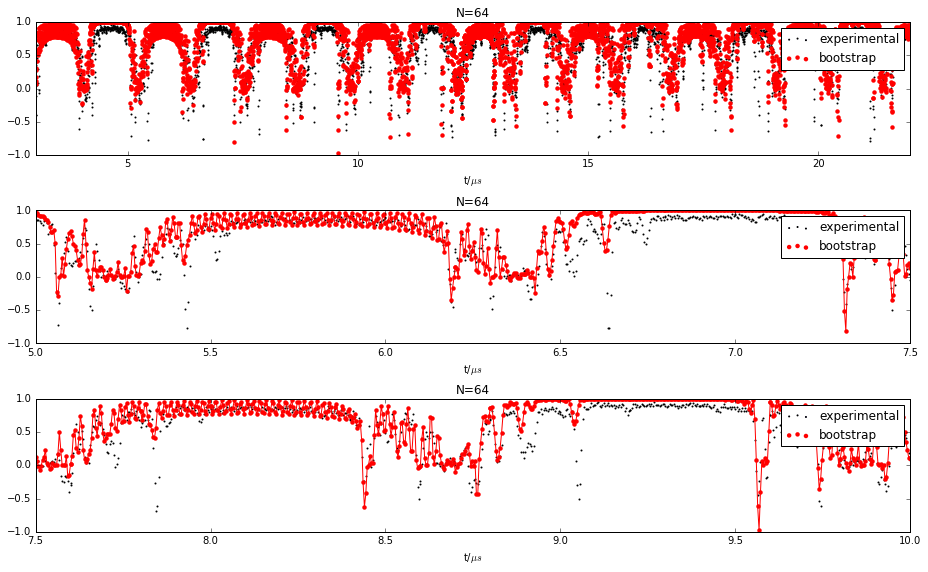

In [182]:
plt.figure(figsize=(13,8))
plt.subplot(3,1,1)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.xlim(min(sil18[64][:,0]),max(sil18[64][:,0]))
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],current_fit,'r')
plt.xlim(5,7.5)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(sil18[64][:,0],sil18[64][:,1],s=1,label='experimental')
#plt.plot(sil18[64][:,0],current_fit,'r',label='fit')
plt.scatter(sil18[64][:,0],current_fit,c='r',label='bootstrap',lw=0.)
plt.plot(sil18[64][:,0],current_fit,'r')
plt.xlim(7.5,10)
plt.ylim(-1,1)
plt.title('N=64')
plt.xlabel('t/$\mu s$')
plt.legend()
plt.tight_layout()
plt.show()

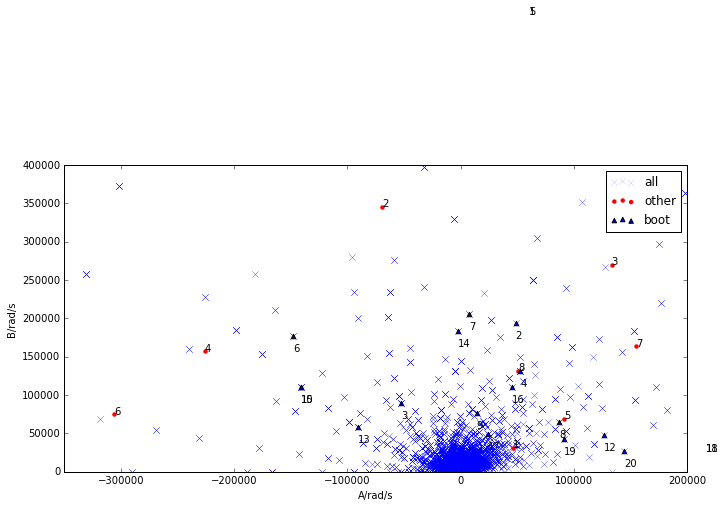

In [194]:
plt.figure(figsize=(10,5))
plt.scatter(all_spins[:,0],all_spins[:,1],marker='x',s=40,lw=0.1,label='all')
plt.scatter(par_params,perp_params,c='r',lw=0,label='other')
plt.scatter(fitted_As,fitted_Bs,marker='^',label='boot')
plt.xlim(-350000,200000)
plt.ylim(0,400000)
plt.xlabel('A/rad/s')
plt.ylabel('B/rad/s')
for i in range(len(par_params)):
    plt.text(par_params[i],perp_params[i],str(i+1))
for i in range(len(fitted_As)):
    plt.text(fitted_As[i],fitted_Bs[i]-20000,str(i+1))
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df